In [ ]:
# Copyright 2021 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

<img src="http://developer.download.nvidia.com/compute/machine-learning/frameworks/nvidia_logo.png" style="width: 90px; float: right;">

# NVTabular demo on Rossmann data - Feature Engineering & Preprocessing

## Overview

NVTabular is a feature engineering and preprocessing library for tabular data designed to quickly and easily manipulate terabyte scale datasets used to train deep learning based recommender systems.  It provides a high level abstraction to simplify code and accelerates computation on the GPU using the RAPIDS cuDF library.

### Learning objectives

This notebook demonstrates the steps for carrying out data preprocessing, transformation and loading with NVTabular on the Kaggle Rossmann [dataset](https://www.kaggle.com/c/rossmann-store-sales/overview).  Rossmann operates over 3,000 drug stores in 7 European countries. Historical sales data for 1,115 Rossmann stores are provided. The task is to forecast the "Sales" column for the test set. 

The following example will illustrate how to use NVTabular to preprocess and feature engineer the data for futher training deep learning models. We provide notebooks for training neural networks in [TensorFlow](https://github.com/NVIDIA/NVTabular/blob/main/examples/99-applying-to-other-tabular-data-problems-rossmann/03a-Training-with-TF.ipynb), [PyTorch](https://github.com/NVIDIA/NVTabular/blob/main/examples/99-applying-to-other-tabular-data-problems-rossmann/03b-Training-with-PyTorch.ipynb) and [FastAI](https://github.com/NVIDIA/NVTabular/blob/main/examples/99-applying-to-other-tabular-data-problems-rossmann/04-Training-with-FastAI.ipynb). We'll use a [dataset built by FastAI](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson6-rossmann.ipynb) for solving the [Kaggle Rossmann Store Sales competition](https://www.kaggle.com/c/rossmann-store-sales). Some cuDF preprocessing is required to build the appropriate feature set, so make sure to run [01-Download-Convert.ipynb](https://github.com/NVIDIA/NVTabular/blob/main/examples/99-applying-to-other-tabular-data-problems-rossmann/01-Download-Convert.ipynb) first before going through this notebook.

In [2]:
import os
import json
import nvtabular as nvt

from nvtabular import ops

## Preparing our dataset
Let's start by defining some of the a priori information about our data, including its schema (what columns to use and what sorts of variables they represent), as well as the location of the files corresponding to some particular sampling from this schema. Note that throughout, I'll use UPPERCASE variables to represent this sort of a priori information that you might usually encode using commandline arguments or config files.<br><br>
We use the data schema to define our pipeline.

In [3]:
DATA_DIR = os.environ.get(
    "OUTPUT_DATA_DIR", os.path.expanduser("~/nvt-examples/data/")
)

CATEGORICAL_COLUMNS = [
    "Store",
    "DayOfWeek",
    "Year",
    "Month",
    "Day",
    "StateHoliday",
    "CompetitionMonthsOpen",
    "Promo2Weeks",
    "StoreType",
    "Assortment",
    "PromoInterval",
    "CompetitionOpenSinceYear",
    "Promo2SinceYear",
    "State",
    "Week",
    "Events",
    "Promo_fw",
    "Promo_bw",
    "StateHoliday_fw",
    "StateHoliday_bw",
    "SchoolHoliday_fw",
    "SchoolHoliday_bw",
]

CONTINUOUS_COLUMNS = [
    "CompetitionDistance",
    "Max_TemperatureC",
    "Mean_TemperatureC",
    "Min_TemperatureC",
    "Max_Humidity",
    "Mean_Humidity",
    "Min_Humidity",
    "Max_Wind_SpeedKm_h",
    "Mean_Wind_SpeedKm_h",
    "CloudCover",
    "trend",
    "trend_DE",
    "AfterStateHoliday",
    "BeforeStateHoliday",
    "Promo",
    "SchoolHoliday",
]
LABEL_COLUMNS = ["Sales"]

COLUMNS = CATEGORICAL_COLUMNS + CONTINUOUS_COLUMNS + LABEL_COLUMNS

What files are available to train on in our data directory?

In [4]:
! ls $DATA_DIR

output.csv		  test.csv			    valid.csv
ross_pre		  test_inference_rossmann_data.csv  workflow
rossmann_predictions.csv  train.csv


`train.csv` and `valid.csv` seem like good candidates, let's use those.

In [5]:
TRAIN_PATH = os.path.join(DATA_DIR, "train.csv")
VALID_PATH = os.path.join(DATA_DIR, "valid.csv")

### Defining our Data Pipeline
The first step is to define the feature engineering and preprocessing pipeline.<br><br>
NVTabular has already implemented multiple calculations, called `ops`. An `op` can be applied to a `ColumnGroup` from an overloaded `>>` operator, which in turn returns a new `ColumnGroup`. A `ColumnGroup` is a list of column names as text.<br><br>
**Example:**<br>
features = [*\<column name\>*, ...] >> *\<op1\>* >> *\<op2\>* >> ...

This may sounds more complicated as it is. Let's define our first pipeline for the Rossmann dataset. <br><br>We need to categorify the categorical input features. This converts the categorical values of a feature into continuous integers (0, ..., |C|), which is required by an embedding layer of a neural network.

* Initial `ColumnGroup` is `CATEGORICAL_COLUMNS`
* `Op` is `Categorify`

In [6]:
cat_features = CATEGORICAL_COLUMNS >> ops.Categorify()

We can visualize the calculation with `graphviz`.

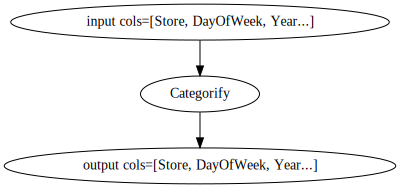

In [7]:
(cat_features).graph

Our next step is to process the continuous columns. We want to fill in missing values and normalize the continuous features with mean=0 and std=1.

* Initial `ColumnGroup` is `CONTINUOUS_COLUMNS`
* First `Op` is `FillMissing`
* Second `Op` is `Normalize`

In [8]:
cont_features = CONTINUOUS_COLUMNS >> ops.FillMissing() >> ops.Normalize()

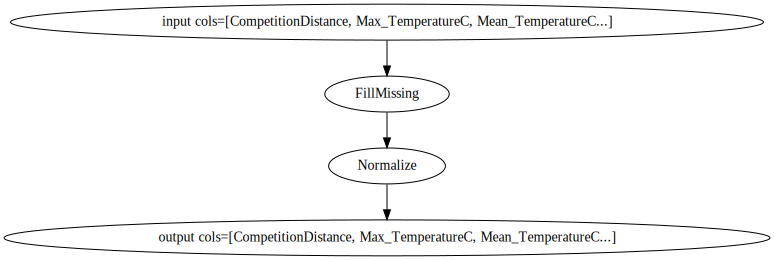

In [9]:
(cont_features).graph

Finally, we need to apply the LogOp to the label/target column.

In [10]:
label_feature = LABEL_COLUMNS >> ops.LogOp()

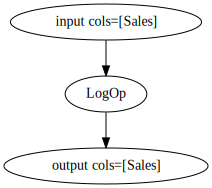

In [11]:
(label_feature).graph

We can visualize the full workflow by concatenating the output `ColumnGroups`.

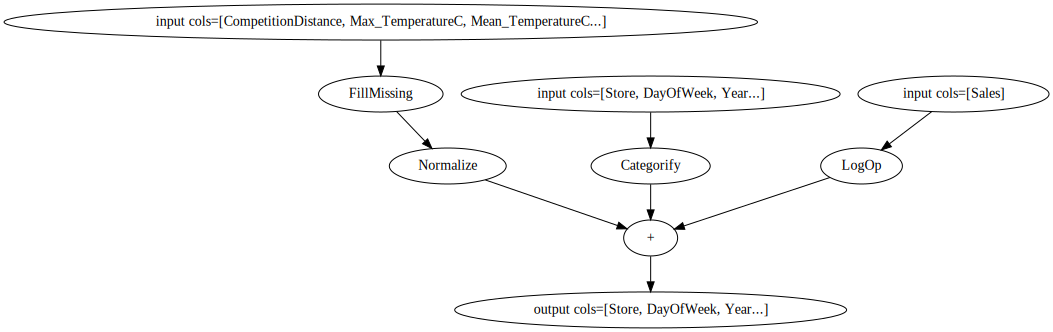

In [12]:
(cat_features + cont_features + label_feature).graph

### Workflow

A NVTabular `workflow` orchastrates the pipelines. We initalize the NVTabular `workflow` with the output `ColumnGroups`.

In [13]:
proc = nvt.Workflow(cat_features + cont_features + label_feature)

### Datasets
In general, the `Op`s in our `Workflow` will require measurements of statistical properties of our data in order to be leveraged. For example, the `Normalize` op requires measurements of the dataset mean and standard deviation, and the `Categorify` op requires an accounting of all the categories a particular feature can manifest. However, we frequently need to measure these properties across datasets which are too large to fit into GPU memory (or CPU memory for that matter) at once.

NVTabular solves this by providing the `Dataset` class, which breaks a set of parquet or csv files into into a collection of `cudf.DataFrame` chunks that can fit in device memory.  Under the hood, the data decomposition corresponds to the construction of a [dask_cudf.DataFrame](https://docs.rapids.ai/api/cudf/stable/dask-cudf.html) object.  By representing our dataset as a lazily-evaluated [Dask](https://dask.org/) collection, we can handle the calculation of complex global statistics (and later, can also iterate over the partitions while feeding data into a neural network).



In [14]:
train_dataset = nvt.Dataset(TRAIN_PATH)
valid_dataset = nvt.Dataset(VALID_PATH)

In [15]:
PREPROCESS_DIR = os.path.join(DATA_DIR, "ross_pre/")
PREPROCESS_DIR_TRAIN = os.path.join(PREPROCESS_DIR, "train")
PREPROCESS_DIR_VALID = os.path.join(PREPROCESS_DIR, "valid")

! rm -rf $PREPROCESS_DIR # remove previous trials
! mkdir -p $PREPROCESS_DIR_TRAIN
! mkdir -p $PREPROCESS_DIR_VALID

Now that we have our datasets, we'll apply our `Workflow` to them and save the results out to parquet files for fast reading at train time. Similar to the `scikit learn` API, we collect the statistics of our train dataset with `.fit`.

In [16]:
proc.fit(train_dataset)

We apply and transform our dataset with `.transform` and presist it to disk with `.to_parquet`. We want to shuffle our train dataset before storing to disk to provide more randomness during our deep learning training.

In [17]:
proc.transform(train_dataset).to_parquet(PREPROCESS_DIR_TRAIN, shuffle=nvt.io.Shuffle.PER_WORKER)
proc.transform(valid_dataset).to_parquet(PREPROCESS_DIR_VALID, shuffle=None)

Then, we save the workflow to be used by the Triton export functions for inference.

In [18]:
proc.save(os.path.join(DATA_DIR, "workflow"))

### Finalize embedding tables

In the next steps, we will train a deep learning model with either TensorFlow, PyTorch or FastAI. Our training pipeline requires information about the data schema to define the neural network architecture. In addition, we store the embedding tables structure.

In [19]:
EMBEDDING_TABLE_SHAPES = nvt.ops.get_embedding_sizes(proc)
EMBEDDING_TABLE_SHAPES

{'Assortment': (4, 16),
 'CompetitionMonthsOpen': (26, 16),
 'CompetitionOpenSinceYear': (24, 16),
 'Day': (32, 16),
 'DayOfWeek': (8, 16),
 'Events': (22, 16),
 'Month': (13, 16),
 'Promo2SinceYear': (9, 16),
 'Promo2Weeks': (27, 16),
 'PromoInterval': (4, 16),
 'Promo_bw': (9, 16),
 'Promo_fw': (9, 16),
 'SchoolHoliday_bw': (9, 16),
 'SchoolHoliday_fw': (9, 16),
 'State': (13, 16),
 'StateHoliday': (3, 16),
 'StateHoliday_bw': (6, 16),
 'StateHoliday_fw': (6, 16),
 'Store': (1116, 81),
 'StoreType': (5, 16),
 'Week': (53, 16),
 'Year': (4, 16)}

In [20]:
json.dump(
    {
        "EMBEDDING_TABLE_SHAPES": EMBEDDING_TABLE_SHAPES,
        "CATEGORICAL_COLUMNS": CATEGORICAL_COLUMNS,
        "CONTINUOUS_COLUMNS": CONTINUOUS_COLUMNS,
        "LABEL_COLUMNS": LABEL_COLUMNS,
    },
    open(PREPROCESS_DIR + "/stats.json", "w"),
)

In [21]:
!ls $PREPROCESS_DIR

stats.json  train  valid
